In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

In [77]:
# Función para descargar datos de yfinance y calcular mu y sigma
def get_data(ticker, start, end):
    prices = yf.download(ticker, start=start, end=end, progress=False)['Close']
    returns = prices.pct_change().dropna()
    mu = returns.mean()
    sigma = returns.std()
    return prices, mu, sigma

# Función para simular rendimientos futuros
def simular_precios(mu, sigma, num_dias):
    Z = np.random.normal(0, 1, num_dias)
    simulated_returns = np.array(mu) + np.array(sigma) * Z

    cumulative_returns = np.insert((1 + simulated_returns).cumprod(), 0, 1)

    capital = 5000 # Capital inicial de la inversión única
    n_dias_dca = int((capital / 100) * 5) - 5  # 50 semanas * 5 días para alcanzar el mismo capital inicial

    # Estrategia 1: inversión única
    inv_unica = capital * cumulative_returns

    # Estrategia 2: DCA
    inv_dca = np.zeros(num_dias + 1)
    inv_dca[0] = 100

    for i in range(num_dias):
        inv_dca[i + 1] = inv_dca[i] * (1 + simulated_returns[i])  # Actualizar valor de la inversión
        
        if (i + 1) % 5 == 0 and (i + 1) <= n_dias_dca:  # Esto asegura que se inviertan $100 cada semana (5 días)
            inv_dca[i + 1] += 100

    return inv_unica, inv_dca


In [78]:
ticker = 'ORCL'
start = '2018-01-01'
end = '2025-01-01'

num_sim= 10000
num_dias = 260

precios, mu, sigma = get_data(ticker, start, end)

sim_inv_unica= np.zeros((num_sim, num_dias + 1))  # Simular inversión única
sim_inv_dca= np.zeros((num_sim, num_dias + 1))  # Simular DCA

for i in range(num_sim):

    inv_unica, inv_dca = simular_precios(mu, sigma, num_dias)
    sim_inv_unica[i, :] = inv_unica
    sim_inv_dca[i, :] = inv_dca


In [79]:
pf_inv_unica = sim_inv_unica[:, -1]  # Lista de valores finales de la inversión única
pf_inv_dca = sim_inv_dca[:, -1]  # Lista de valores finales de la inversión DCA

In [80]:
mean_inv_unica = np.mean(pf_inv_unica) # Media del valor final de la inversión única
mean_inv_dca = np.mean(pf_inv_dca) # Media del valor final de la inversión DCA

std_inv_unica = np.std(pf_inv_unica) # Desviación estándar del valor final de la inversión única
std_inv_dca = np.std(pf_inv_dca) # Desviación estándar del valor final de la inversión DCA

perdida_inv_unica = np.mean(pf_inv_unica < 5000) # Probabilidad de pérdida (valor final < inversión inicial)
perdida_inv_dca = np.mean(pf_inv_dca < 5000) # Probabilidad de pérdida (valor final < inversión inicial)

resultados = pd.DataFrame({
    'Estrategia': ['Inversión Única', 'DCA'],
    'Media': [mean_inv_unica, mean_inv_dca],
    'Desviación Estándar': [std_inv_unica, std_inv_dca],
    'Probabilidad de Pérdida (%)': [perdida_inv_unica * 100, perdida_inv_dca * 100]
})

resultados

,Estrategia,Media,Desviación Estándar,Probabilidad de Pérdida (%)
0,Inversión Única,6404.747589,1995.781162,25.05
1,DCA,5710.994251,1099.147366,27.17


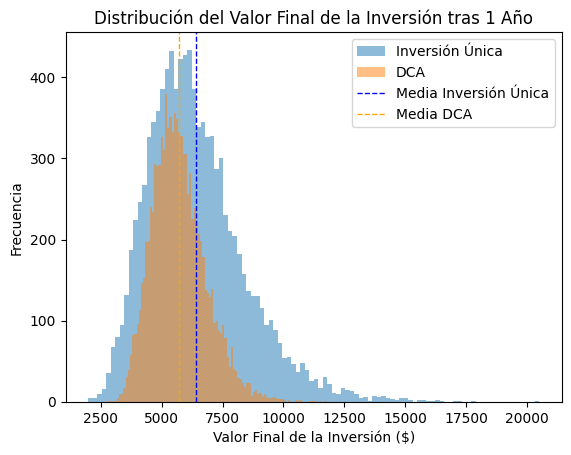

In [81]:
# Histogramas de los valores finales de las inversiones

plt.hist(pf_inv_unica, bins=100, alpha=0.5, label='Inversión Única')
plt.hist(pf_inv_dca, bins=100, alpha=0.5, label='DCA')
plt.axvline(mean_inv_unica, color='blue', linestyle='dashed', linewidth=1, label='Media Inversión Única')
plt.axvline(mean_inv_dca, color='orange', linestyle='dashed', linewidth=1, label='Media DCA')
plt.legend()
plt.xlabel('Valor Final de la Inversión ($)')
plt.ylabel('Frecuencia')
plt.title('Distribución del Valor Final de la Inversión tras 1 Año')
plt.show()

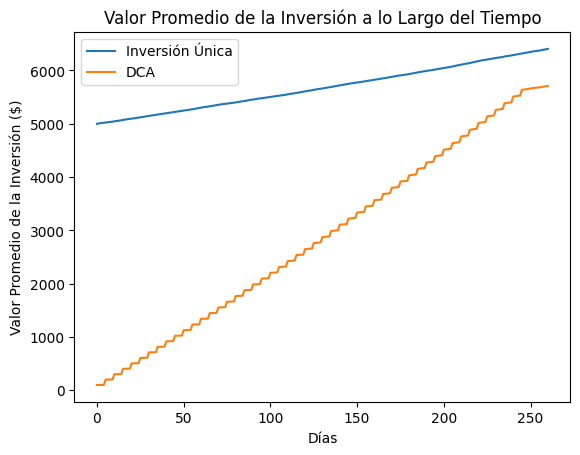

In [82]:
# Gráfica del valor promedio de la inversión a lo largo del tiempo

mean_inv_unica = np.mean(sim_inv_unica, axis=0) # El axis=0 calcula la media a lo largo de las simulaciones
mean_inv_dca = np.mean(sim_inv_dca, axis=0)

plt.plot(mean_inv_unica, label='Inversión Única')
plt.plot(mean_inv_dca, label='DCA')
plt.xlabel('Días')
plt.ylabel('Valor Promedio de la Inversión ($)')
plt.title('Valor Promedio de la Inversión a lo Largo del Tiempo')
plt.legend()
plt.show()